In [1]:
import numpy as np
from wLSM_utils import *
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed as ASE
from graspy.cluster import GaussianCluster as GCLUST

from itertools import combinations
from scipy.stats import norm
import scipy.optimize as optimize
from sklearn.metrics import adjusted_rand_score as ari

from graspy.datasets import load_drosophila_left, load_drosophila_right
from graspy.utils import binarize

import matplotlib.pyplot as plt

%matplotlib inline

left_adj, left_labels = load_drosophila_left(return_labels=True)
right_adj, right_labels = load_drosophila_right(return_labels=True)

In [2]:
def quadratic(data, params):
    if data.ndim == 1:
        sum_ = np.sum(data[:-1]**2 * params[:-1]) + params[-1]
        return sum_
    elif data.ndim == 2:
        sums = np.sum(data[:, :-1]**2 * params[:-1], axis = 1) + params[-1]
        return sums
    else:
        raise ValueError("unsuppored data")
        
def quadratic_log_likelihood(data, params):
    n, d = data.shape
    fitted_Z = quadratic(data, params)
    residuals = fitted_Z - data[:, -1] # assuming data.ndim == 2
    std = np.std(residuals, ddof=1)
    
    log_likelihood = 0
    for i in range(n):
        log_likelihood += np.log(norm.pdf(residuals[i], fitted_Z[i], std))
        
    return log_likelihood

def func(data, a, b, c, d, e, f):
    return a*(data[:, 0])**2 + b*data[:, 1]**2 + c*(data[:, 2])**2 + d*data[:, 3]**2 + e*(data[:, 4])**2 + f

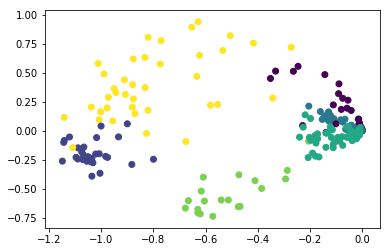

In [3]:
np.random.seed(16661)
A_right = binarize(right_adj)
X_hat_right = np.concatenate(ASE(n_components=3).fit_transform(A_right), axis=1)
n, d = X_hat_right.shape

gclust_right = GCLUST(max_components=15)
c_hat_right = gclust_right.fit_predict(X_hat_right)
unique_labels = np.unique(c_hat_right)
K = len(unique_labels)

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat_right[:, 0], X_hat_right[:, 1], c=c_hat_right)

In [4]:
class_idx = np.array([np.where(c_hat_right == u)[0] for u in unique_labels])

loglikelihoods_right = [np.sum(gclust_right.model_.score_samples(X_hat_right))]
combos = [None]
aris_right = [ari(right_labels, c_hat_right)]
bic_right = [gclust_right.model_.bic(X_hat_right)]

# Plot for each fitted quad
for k in range(len(unique_labels)):
    for combo in list(combinations(np.unique(c_hat_right), k+1)):
        combo = np.array(list(combo)).astype(int)
        combos.append(combo)
        print(combo)
        temp_K = K - len(combo)
        temp_mean_params = temp_K * d
        temp_cov_params = temp_K * d * (d + 1) / 2
        temp_quad_params = (d - 1)*2 + d
        temp_n_params = temp_mean_params + temp_cov_params
        temp_n_params = temp_quad_params + temp_K - 1
        
        temp_quad_labels = np.concatenate(class_idx[combo])
        
        temp_label = min(combo)
        temp_n = len(temp_quad_labels)

        temp_c_hat = c_hat_right.copy()
        temp_c_hat[temp_quad_labels] = temp_label
        
        maxes = np.array([max(X_hat_right[temp_quad_labels, i]) for i in range(X_hat_right.shape[1] - 1)])
        mins = np.array([min(X_hat_right[temp_quad_labels, i]) for i in range(X_hat_right.shape[1] - 1)])
        area = np.prod(maxes - mins)
        log_A = temp_n * np.log(1/area)
        
        guess = (1,1,1,1,1,1)
        params, pcov = optimize.curve_fit(func, X_hat_right[temp_quad_labels, :5], X_hat_right[temp_quad_labels, 5], guess)
        
        fitted_Z = quadratic(X_hat_right, params)
        temp_Z = X_hat_right[:, 2].copy()
        temp_Z[temp_quad_labels] = fitted_Z[temp_quad_labels]
        
        quad_log_likelihood = quadratic_log_likelihood(X_hat_right[temp_quad_labels], params)
        gmm_log_likelihood = np.sum(gclust_right.model_.score_samples(X_hat_right[-temp_quad_labels]))
        
        loglikelihoods_right.append(quad_log_likelihood + gmm_log_likelihood + log_A)
        aris_right.append(ari(right_labels, temp_c_hat))
        bic_right.append(2*gmm_log_likelihood*(n - temp_n) -
                        temp_n_params * np.log(n - temp_n))

[0]
[1]
[2]
[3]
[4]
[5]
[0 1]
[0 2]
[0 3]
[0 4]
[0 5]
[1 2]
[1 3]
[1 4]
[1 5]
[2 3]
[2 4]
[2 5]
[3 4]
[3 5]
[4 5]
[0 1 2]
[0 1 3]
[0 1 4]
[0 1 5]
[0 2 3]
[0 2 4]
[0 2 5]
[0 3 4]
[0 3 5]
[0 4 5]
[1 2 3]
[1 2 4]
[1 2 5]
[1 3 4]
[1 3 5]
[1 4 5]
[2 3 4]
[2 3 5]
[2 4 5]
[3 4 5]
[0 1 2 3]
[0 1 2 4]
[0 1 2 5]
[0 1 3 4]
[0 1 3 5]
[0 1 4 5]
[0 2 3 4]
[0 2 3 5]
[0 2 4 5]
[0 3 4 5]
[1 2 3 4]
[1 2 3 5]
[1 2 4 5]
[1 3 4 5]
[2 3 4 5]
[0 1 2 3 4]
[0 1 2 3 5]
[0 1 2 4 5]
[0 1 3 4 5]
[0 2 3 4 5]
[1 2 3 4 5]
[0 1 2 3 4 5]


max ari: 0.9166976099735417


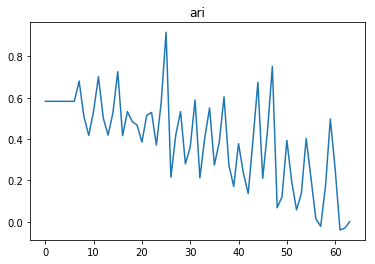

In [5]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), aris_right)
ax.set_title('ari')
print('max ari: ' + str(max(aris_right)))

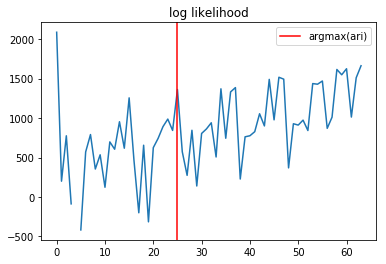

In [6]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), loglikelihoods_right)
ax.set_title('log likelihood')
ax.axvline(x=np.argmax(aris_right), c='r', label='argmax(ari)')
ax.legend()

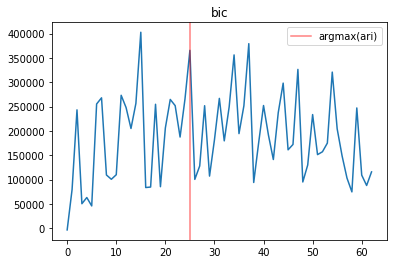

In [13]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), bic_right)
ax.set_title('bic')
ax.axvline(x=np.argmax(aris_right), c='r', label='argmax(ari)', alpha=0.5)
ax.legend()

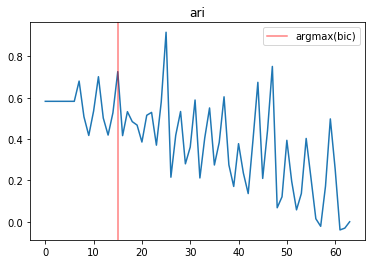

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), aris_right)
ax.set_title('ari')
ax.axvline(x=np.argmax(bic_right[:-1]), c='r', label='argmax(bic)', alpha=0.5)
ax.legend()

Text(0.5, 1.0, 'Original clustering')

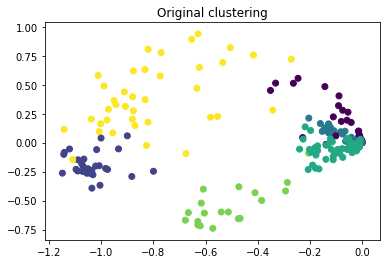

In [15]:
fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat_right[:, 0], X_hat_right[:, 1], c=c_hat_right)
ax.set_title('Original clustering')

Text(0.5, 1.0, 'Clustering with highest ARI')

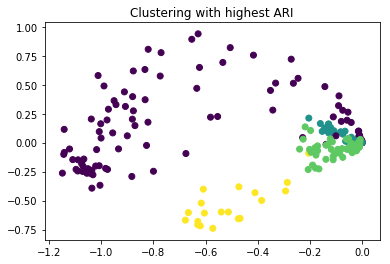

In [16]:
best_combo = combos[np.argmax(aris_right)]
temp_quad_labels = np.concatenate(class_idx[best_combo])
temp_label = min(best_combo)
temp_n = len(temp_quad_labels)

temp_c_hat = c_hat_right.copy()
temp_c_hat[temp_quad_labels] = temp_label

maxes = np.array([max(X_hat_right[temp_quad_labels, i]) for i in range(X_hat_right.shape[1] - 1)])
mins = np.array([min(X_hat_right[temp_quad_labels, i]) for i in range(X_hat_right.shape[1] - 1)])
area = np.prod(maxes - mins)
log_A = temp_n * np.log(1/area)

guess = (1,1,1,1,1,1)
params, pcov = optimize.curve_fit(func, X_hat_right[temp_quad_labels, :5], X_hat_right[temp_quad_labels, 2], guess)

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat_right[:, 0], X_hat_right[:, 1], c=temp_c_hat)
ax.set_title('Clustering with highest ARI')

Text(0.5, 1.0, 'Clustering with highest BIC')

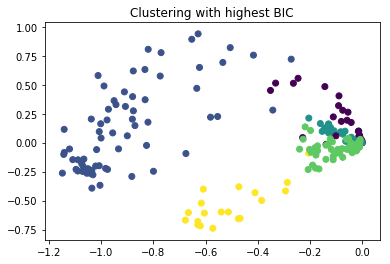

In [17]:
bic_combo = combos[np.argmax(bic_right[:-1])]
temp_quad_labels = np.concatenate(class_idx[bic_combo])
temp_label = min(bic_combo)
temp_n = len(temp_quad_labels)

temp_c_hat = c_hat_right.copy()
temp_c_hat[temp_quad_labels] = temp_label

maxes = np.array([max(X_hat_right[temp_quad_labels, i]) for i in range(X_hat_right.shape[1] - 1)])
mins = np.array([min(X_hat_right[temp_quad_labels, i]) for i in range(X_hat_right.shape[1] - 1)])
area = np.prod(maxes - mins)
log_A = temp_n * np.log(1/area)

guess = (1,1,1,1,1,1)
params, pcov = optimize.curve_fit(func, X_hat_right[temp_quad_labels, :5], X_hat_right[temp_quad_labels, 2], guess)

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat_right[:, 0], X_hat_right[:, 1], c=temp_c_hat)
ax.set_title('Clustering with highest BIC')